In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
import torchvision  # 导入torchvision库
from torchvision.transforms import ToTensor  #做好准备工作，导入所需要的包`b

In [2]:
train_ds=torchvision.datasets.MNIST('data/',train=True,transform=ToTensor(),download=True)
print(type(train_ds))

<class 'torchvision.datasets.mnist.MNIST'>


In [3]:
test_ds=torchvision.datasets.MNIST('data/',train=False,transform=ToTensor(),download=True)

In [4]:
train_dl=torch.utils.data.DataLoader(train_ds,batch_size=64,shuffle=True)
test_dl=torch.utils.data.DataLoader(test_ds,batch_size=46)

In [5]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        # 第一层输入展评后的特征长度28*28
        self.liner_1 = nn.Linear(28 * 28, 120)
        # 第二层输入的是前一层的输出，创建了84个神经元
        self.liner_2 = nn.Linear(120, 84)
        # 输出层就收第二层的输入84，输出分类个数10
        self.liner_3 = nn.Linear(84, 10)

    def forward(self, input):
        x = input.view(-1, 28 * 28)  # 将输入展平为二维，（1,28,28）→（28*28）
        x = torch.relu(self.liner_1(x))  # 连接第一层linear_1并使用ReLU函数激活
        x = torch.relu(self.liner_2(x))  # 连接第二层linear_2并使用ReLU函数激活
        x = self.liner_3(x)  # 输出层，输出张量的长度，与类别数量一致
        return x

In [6]:
loss_fn=nn.CrossEntropyLoss() # 初始化交叉熵损失函数

In [7]:
device="cuda" if torch.cuda.is_available() else "cpu"
print("Using{}device".format(device)) # 如果安装了GPU版本，显示Using cuda device
model=Model().to(device) #初始化模型，并设置模型使用device
optimizer=torch.optim.SGD(model.parameters(),lr=0.002) # 初始化优化器

Usingcudadevice


In [8]:
def train(dataloader,model,loss_fn,optimizer):
    size=len(dataloader.dataset)  # 获取当前数据集样本总数量
    num_batches=len(dataloader)  #获得当前dataloader总批次数
    # train_loss用于累计所有批次的损失之和，correct用于累计预测正确的样本总数
    train_loss,correct=0,0
    for X,y in dataloader:  #对dataloader进行迭代
        X,y=X.to(device),y.to(device)  #每一批次的数据设置为使用当前device进行预测，并计算一个批次的损失
        pred=model(X)
        loss=loss_fn(pred,y)  # 返回的是平均损失
        #使用反向传播算法，根据损失优化模型参数
        optimizer.zero_grad()  #将模型参数的梯度全部归零
        loss.backward()  # 损失反向传播，计算模型参数梯度
        optimizer.step()  # 根据梯度优化参数
        with torch.no_grad():
            # correct 用于累计预测正确的样本总数
            correct+=(pred.argmax(1)==y).type(torch.float).sum().item()
            #train_loss用于累计所有批次的损失之和
            train_loss+=loss.item()
    #train_loss是所有批次的损失之和，所以计算全部样本的平均损失时需要处于总批次数
    train_loss/=num_batches
    #correct是预测正确的样本总是，若计算整个epoch总体正确率，需除以样本总数量
    correct/=size
    return train_loss,correct

In [9]:
def test(dataloader,model):
    size=len(dataloader.dataset)
    num_batches=len(dataloader)
    test_loss,correct=0,0
    with torch.no_grad():
        for X,y in dataloader:
            X,y=X.to(device),y.to(device)
            pred=model(X)
            test_loss+=loss_fn(pred,y).item()
            correct+=(pred.argmax(1)==y).type(torch.float).sum().item()
    test_loss/=num_batches
    correct/=size
    return test_loss,correct

In [10]:
epochs=50  #一个epoch代表对全部数据训练一遍

train_loss=[]  #每个epoch训练中训练数据集的平均损失被添加到此列表
train_acc=[] #每个epoch训练中训练数据集的平均正确率被添加到此列表
test_loss=[]  #每个epoch训练中测试数据集的平均损失被添加到此列表
test_acc=[] #每个epoch训练中测试数据集的平均正确率被添加到此列表

for epoch in range(epochs):
    #调用train()函数训练
    epoch_loss,epoch_acc=train(train_dl,model,loss_fn,optimizer)
    #调用test()函数测试
    epoch_test_loss,epoch_test_acc=test(test_dl,model)
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)
    test_loss.append(epoch_test_loss)
    test_acc.append(epoch_test_acc)
    #定义一个打印模版
    template=("epoch:{:2d},train_loss:{:.5f},train_acc:{:.1f}%,test_loss:{:.5f},test_acc:{:.1f}%")
    #输出当前的epoch的训练集损失、训练集正确率、测试集损失、测试集正确率
    print(template.format(epoch,epoch_loss,epoch_acc*100,epoch_test_loss,epoch_test_acc*100))
    
print("Done!")

epoch: 0,train_loss:2.28042,train_acc:16.3%,test_loss:2.24297,test_acc:28.9%
epoch: 1,train_loss:2.17937,train_acc:42.1%,test_loss:2.07947,test_acc:54.0%
epoch: 2,train_loss:1.91891,train_acc:57.4%,test_loss:1.68858,test_acc:63.8%
epoch: 3,train_loss:1.43468,train_acc:69.2%,test_loss:1.14897,test_acc:79.0%
epoch: 4,train_loss:0.98386,train_acc:80.1%,test_loss:0.80821,test_acc:82.9%
epoch: 5,train_loss:0.73699,train_acc:83.2%,test_loss:0.63798,test_acc:84.9%
epoch: 6,train_loss:0.60769,train_acc:84.9%,test_loss:0.54358,test_acc:86.3%
epoch: 7,train_loss:0.53200,train_acc:86.2%,test_loss:0.48595,test_acc:87.2%
epoch: 8,train_loss:0.48322,train_acc:87.1%,test_loss:0.44593,test_acc:88.0%
epoch: 9,train_loss:0.44957,train_acc:87.8%,test_loss:0.41846,test_acc:88.4%
epoch:10,train_loss:0.42469,train_acc:88.3%,test_loss:0.39829,test_acc:89.0%
epoch:11,train_loss:0.40565,train_acc:88.8%,test_loss:0.38166,test_acc:89.5%
epoch:12,train_loss:0.39046,train_acc:89.1%,test_loss:0.36887,test_acc:89.6%

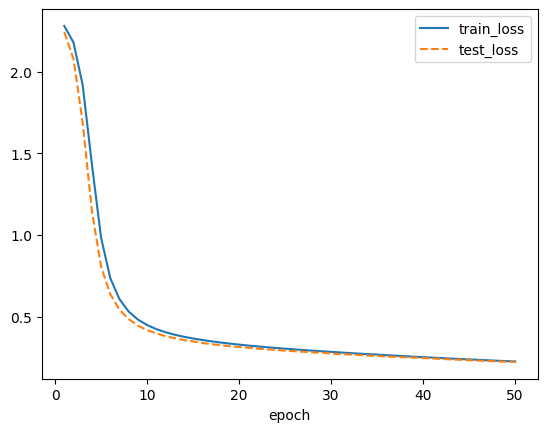

In [11]:
plt.plot(range(1,epochs+1),train_loss,label="train_loss")
plt.plot(range(1,epochs+1),test_loss,label='test_loss',ls="--")
plt.xlabel('epoch')
plt.legend()
plt.show()

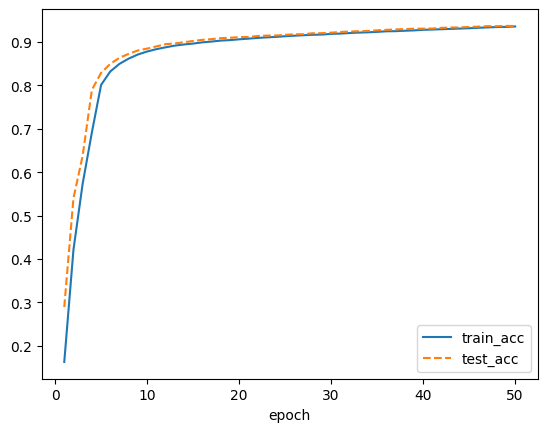

In [12]:
plt.plot(range(1,epochs+1),train_acc,label='train_acc')
plt.plot(range(1,epochs+1),test_acc,label='test_acc',ls="--")
plt.xlabel('epoch')
plt.legend()
plt.show()